In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import spikeforest as sf
import spikeinterface.full as si
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.linear_model import LinearRegression
import yaml
from cdlgr.dataset.dataset import get_dataset
import notebook_helper as helper


## Data overview



### Synthetic dataset

In [3]:
dataset_synth = helper.load_dataset("synth_default_dataset")

#### Signal visualization

Let's visualize the signal.

In [4]:
sw.plot_traces(dataset_synth.recording, time_range=[0, 10], backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

d:\Logiciels\Anaconda3\envs\TS_proj\Lib\site-packages\spikeinterface\widgets\traces.py:268: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(


In [6]:
print("Y-scale present?", dataset_synth.recording.has_scaled())

Y-scale present? False


#### Denoising

In [7]:
print("Noise (median absolute deviation)", si.get_noise_levels(dataset_synth.recording, return_scaled=False, chunk_size=10000))

Noise (median absolute deviation) [0.10105825]


No common noise removal because only one channel.

#### Spectrogram and FFT

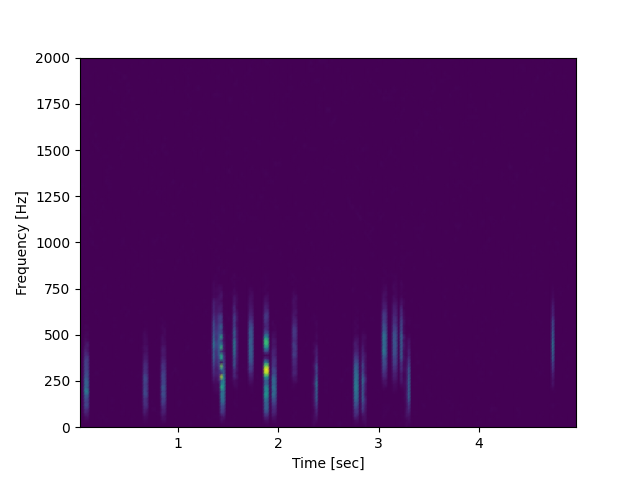

In [8]:
f, t, Sxx = helper.get_spectrogram(dataset_synth.recording, 50000)
plt.figure()
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2000)
plt.show()

10000
(50000, 1) (50000,)


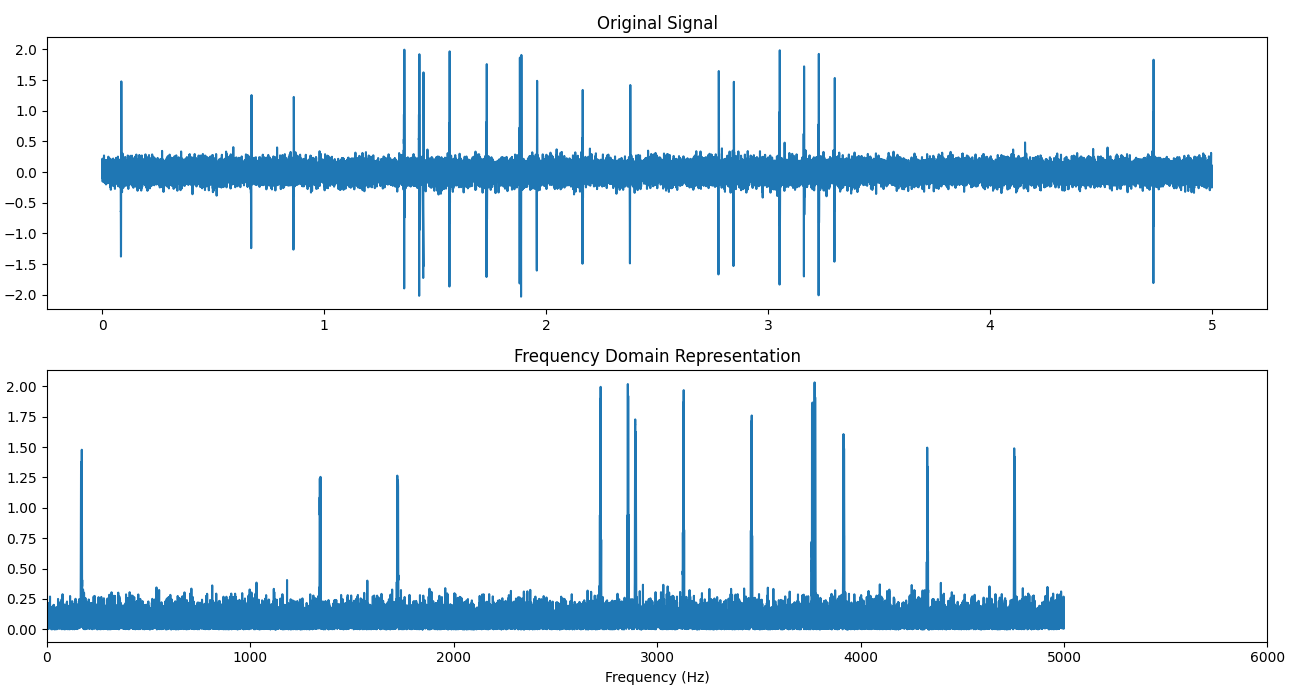

In [9]:
helper.fft_rec(dataset_synth.recording, 50000)

#### Waveforms

extract waveforms shared_memory multi buffer:   0%|          | 0/5 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:   0%|          | 0/5 [00:00<?, ?it/s]

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

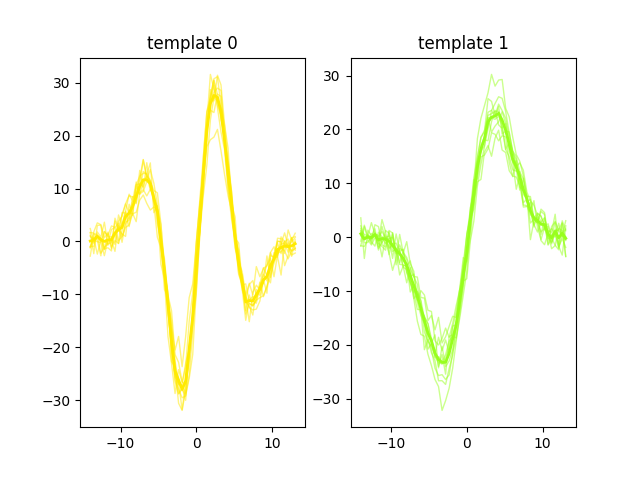

In [35]:
plt.close('all')
waveforms = si.extract_waveforms(dataset_synth.recording, dataset_synth.sorting_true, max_spikes_per_unit=2500, mode="memory", ms_before=3, ms_after=3)
w = sw.plot_spikes_on_traces(waveform_extractor=waveforms, backend="ipywidgets")
sw.plot_unit_waveforms(waveforms)


### Real dataset

First, we need to retrieve the dataset. Here we do not use the function we did so that we can understand the different operations performed.

In [11]:
dataset_real = helper.load_dataset("default_dataset")

You must have set up kachery-cloud (see [here](https://github.com/flatironinstitute/kachery-cloud?tab=readme-ov-file#installation-and-setup)).

In [12]:
sw.plot_traces(dataset_real.recording, time_range=[0, 10], channel_ids=[18],backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [13]:
print(dataset_real.recording.has_scaled())

False


No scaled traces so we cannot have a unit for the y-axis.

#### Stationarity and ergodicity

Given the many spikes, the signal is not stationary and ergodic, but it seems that the background noise is quite stationary over time, which would allow us some basic preprocessing. The use of the median instead of the mean for statistics will make us more robust towards the spiking outliers.

#### Denoising

In [14]:
print(si.get_noise_levels(dataset_real.recording, return_scaled=False, chunk_size=10000)[18])

37.065055462640046


In [15]:
recording_denoised = si.common_reference(dataset_real.recording, reference='global')
print(si.get_noise_levels(recording_denoised, return_scaled=False, chunk_size=10000)[18])

35.58245324413445


In [16]:
recording = recording_denoised.channel_slice([18])

#### Spectrogram and FFT

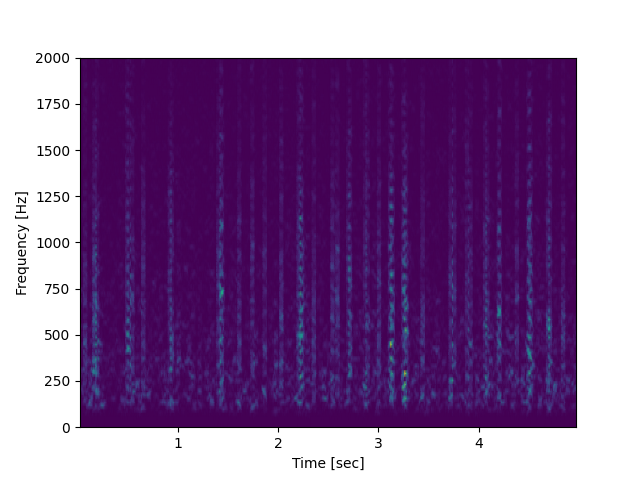

In [17]:
plt.close('all')
f, t, Sxx = signal.spectrogram(recording.get_traces(end_frame=100000).flatten(), recording.get_sampling_frequency(),
                               nperseg=1024, noverlap=1024 - 100, window=('tukey', 0.25))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2000)
plt.show()

Even if the random peaks make the signal non stationary, it can be interesting to compute the FFT to check there is no systematic background noise like for instance some electric resonance around 60 Hz. We can use FFT because we assume there is no abrupt change in the timeseries, except spikes.

In [18]:
print(recording.is_filtered())

False


20000.0
(100000, 1) (100000,)


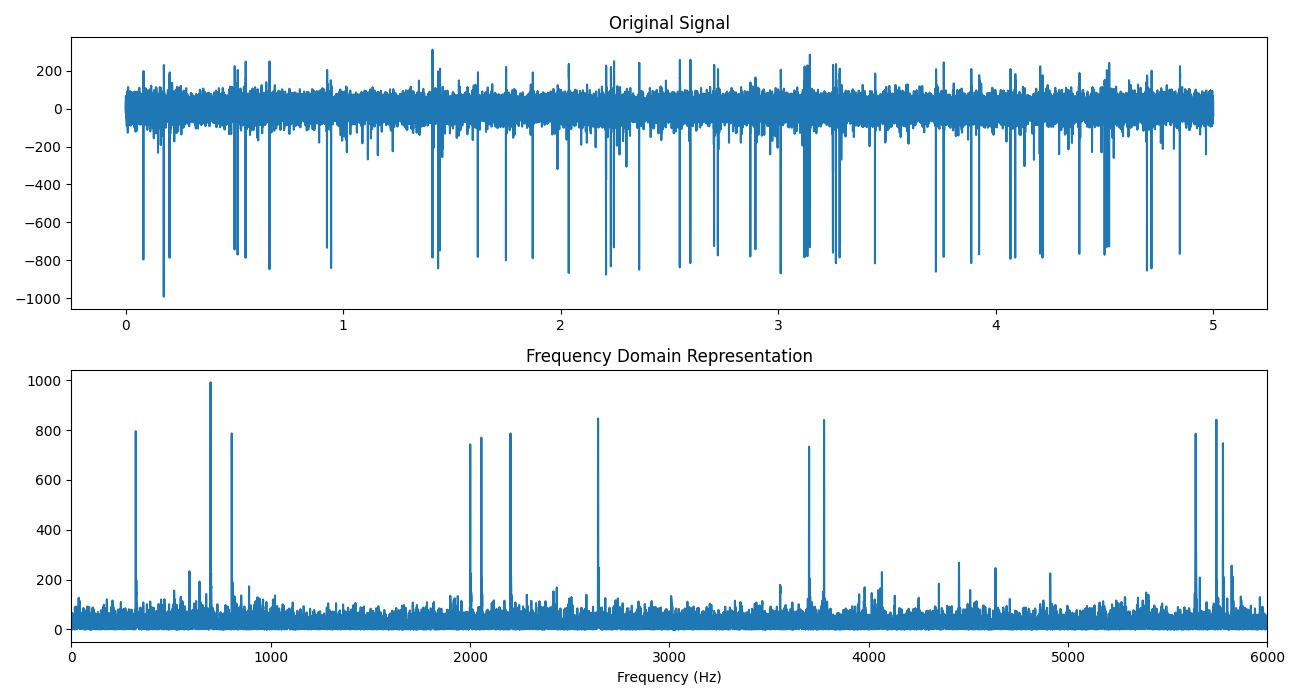

In [19]:
helper.fft_rec(recording)

We filter the signal to keep only the high-frequency components corresponding to the spikes.

20000.0
(100000, 1) (100000,)


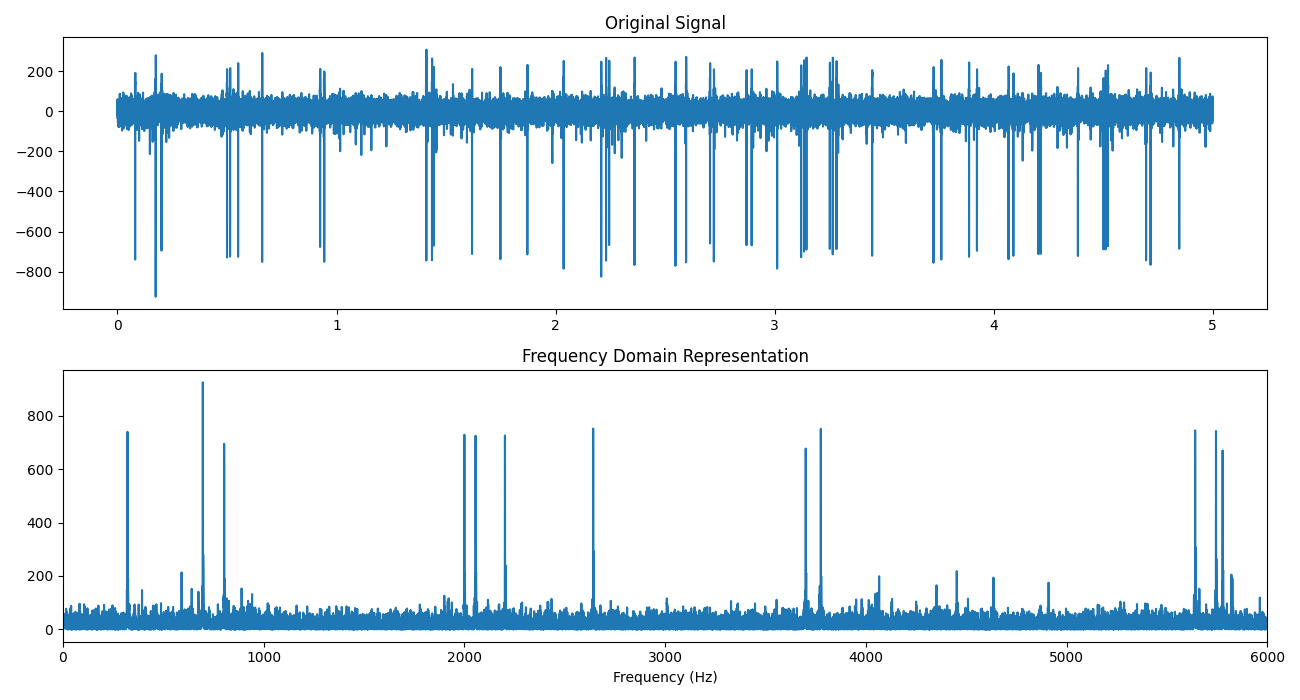

In [20]:
recording_filt = si.bandpass_filter(recording, 300, 6000)
helper.fft_rec(recording_filt)

In fact, contrary to what the recording object indicates, it has already been filtered.

In [21]:
recording.annotate(is_filtered=True)

Plotting autocorrelation does not make a lot of sense here.

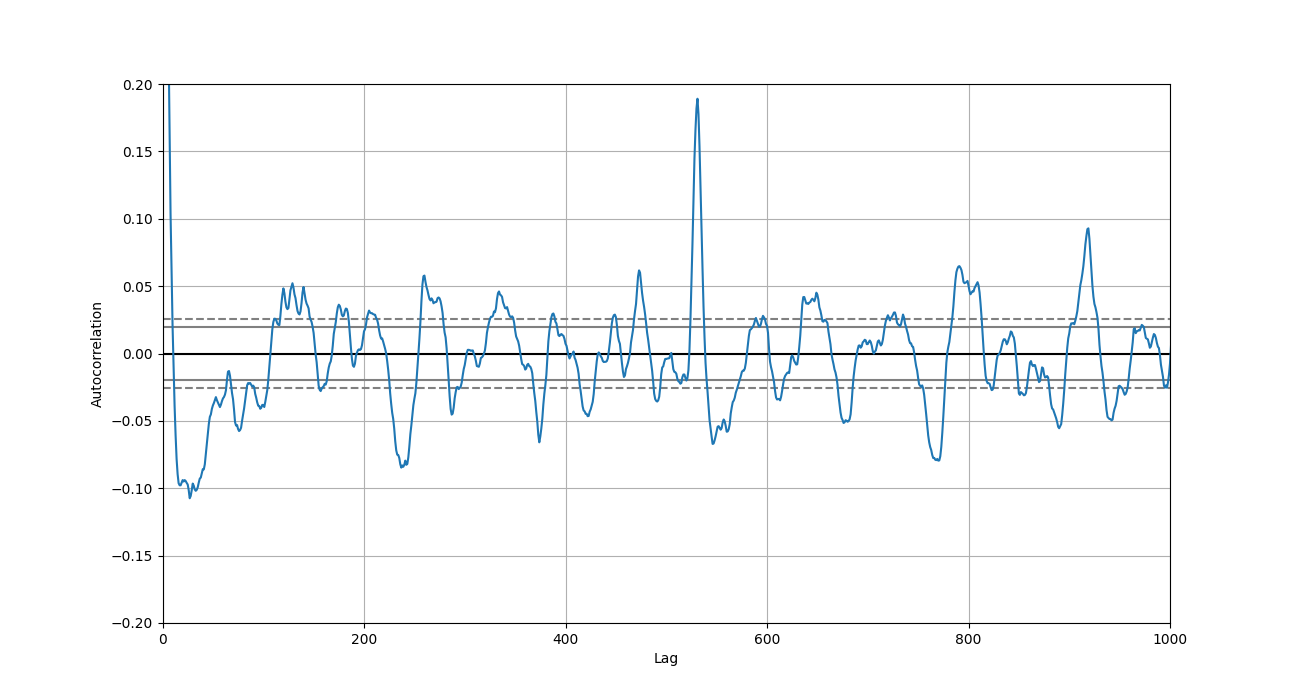

In [22]:
plt.figure(figsize=(13, 7))
pd.plotting.autocorrelation_plot(recording.get_traces(end_frame=10000))
plt.ylim(-0.2, 0.2)
plt.xlim(0, 1000)
plt.show()

#### Detrending

We check if there is no major trend in the signal, even though it does not seem so

Coefficients: [[0.01368777]]


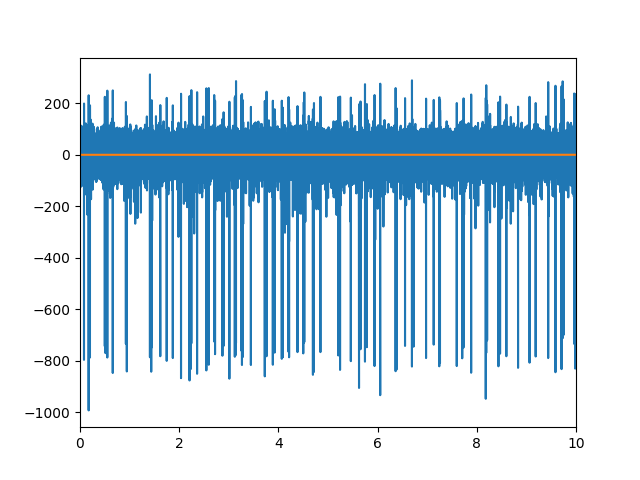

In [23]:
traces = recording.get_traces()
times = np.arange(len(traces)) / recording.get_sampling_frequency()
times = times.reshape((-1, 1))
model = LinearRegression()
model.fit(times, traces)
print('Coefficients: %s' % model.coef_)
# calculate trend
trend = model.predict(times)
# plot trend
plt.figure()
plt.plot(times, traces)
plt.plot(times, trend)
plt.xlim(0, 10)
plt.show()

#### Spikes waveforms

In [24]:
waveforms = si.extract_waveforms(recording, dataset_real.sorting_true, max_spikes_per_unit=2500, mode="memory")

extract waveforms shared_memory multi buffer:   0%|          | 0/10 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory multi buffer:   0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
w = sw.plot_spikes_on_traces(waveform_extractor=waveforms, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

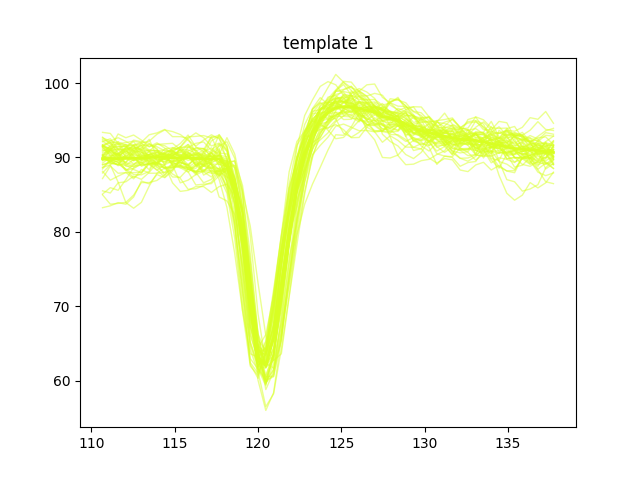

In [26]:
sw.plot_unit_waveforms(waveforms)